In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
data= pd.read_csv('bank-additional-full.csv',sep=';')
print(data.shape)
data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Checking for Duplicates and dropping the duplicate records

In [3]:
print("Number of Duplicate Records-",data[data.duplicated()].shape[0])
data= data.drop_duplicates().reset_index(drop=True)
data.shape

Number of Duplicate Records- 12


(41176, 21)

### Separating categorical and continuous columns for analysis

In [4]:
cont_columns = ['age','campaign','pdays','previous',
               'emp.var.rate', 'cons.price.idx','cons.conf.idx',
                'euribor3m','nr.employed']
categ_columns = ['job','marital','education','default',
                'housing','loan','contact','month','day_of_week',
                'poutcome']

### Data Preprocessing for Continuous Features

* Pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

* Pdays features has a value 999 which is a valid value.
* Replacing 999 with a value equal to 40 for interpretability

In [5]:
data.loc[:,'pdays']= data.pdays.apply(lambda x: 40 if x==999 else x)

In [6]:
data.loc[:,'age'].min(), data.loc[:,'age'].max()
data.loc[data.age>=80,'job'].value_counts()

retired        133
housemaid       13
unknown          2
management       1
blue-collar      1
Name: job, dtype: int64

* From the above age value greater than 80 is making sense. No outlier treatment required 

* All continuous feature are having feasible values and hence no outlier treatment is required 

In [7]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### There are no missing values in the dataset.

#### Handling MultiCollinearity

In [8]:
data.loc[:,cont_columns].corr()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.004622,-0.036313,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
campaign,0.004622,1.000000,0.052697,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
pdays,-0.036313,0.052697,1.000000,-0.585283,0.271014,0.083320,-0.093289,0.294487,0.368147
previous,0.024379,-0.079182,-0.585283,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp.var.rate,-0.000242,0.150786,0.271014,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons.price.idx,0.001009,0.127826,0.083320,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons.conf.idx,0.129075,-0.013657,-0.093289,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,0.135169,0.294487,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr.employed,-0.017607,0.144129,0.368147,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


* 'nr.employed','euribor3m','emp.var.rate','cons.price.idx' 
* These feature are highly correlating among themselves.
* Hence considering only one among them for further analysis

#### Feature Normalization

In [9]:
mod_scale= StandardScaler()
data_cont= pd.DataFrame(mod_scale.fit_transform(data.loc[:,['age','campaign','pdays','previous','emp.var.rate','cons.conf.idx']].values),columns= ['age','campaign','pdays','previous','emp.var.rate','cons.conf.idx'])
data_cont.head()

,age,campaign,pdays,previous,emp.var.rate,cons.conf.idx
0,1.533143,-0.565963,0.194173,-0.349551,0.648101,0.886568
1,1.629107,-0.565963,0.194173,-0.349551,0.648101,0.886568
2,-0.290177,-0.565963,0.194173,-0.349551,0.648101,0.886568
3,-0.002284,-0.565963,0.194173,-0.349551,0.648101,0.886568
4,1.533143,-0.565963,0.194173,-0.349551,0.648101,0.886568


#### Feature Transformation

* Transforming each feature to Normal distribution using boxcox power transformation

age
-1


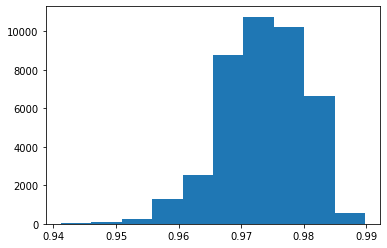

-0.5


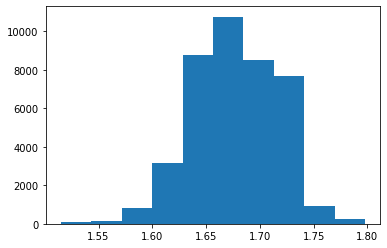

0.0


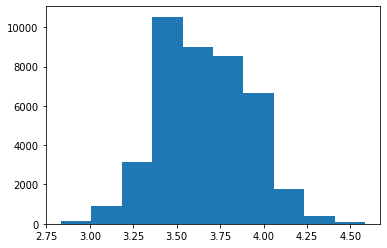

0.5


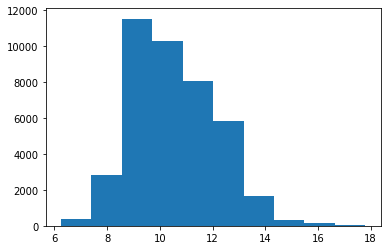

1.0


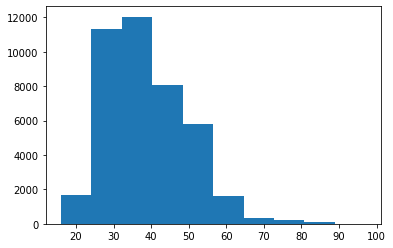

campaign
-1


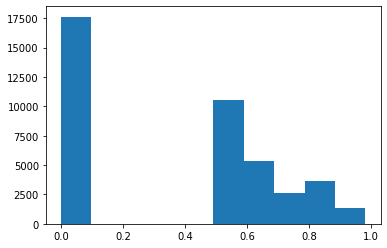

-0.5


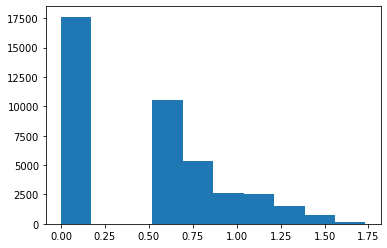

0.0


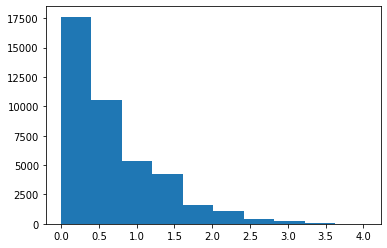

0.5


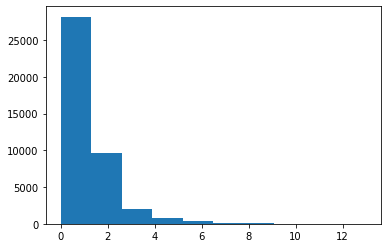

1.0


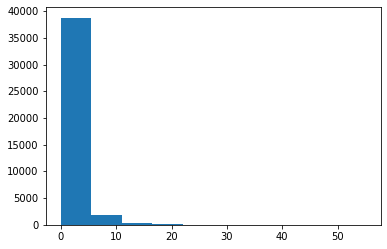

In [14]:

for feature in ['age','campaign']:
    print(feature)
    for lam in [-1,-0.5,0,0.5,1.0]:
        print(lam)
        plt.hist(boxcox(data[feature],lam))
        plt.show()


# * Transforming all continuous variables using Boxcox transformations

In [15]:
data_cont= pd.DataFrame(data=pd.concat([pd.Series(boxcox(data['age'],-0.5),name='age'), pd.Series(boxcox(data['campaign'],-0.5),name='campaign'),
           pd.Series(boxcox(data['pdays']+1,0.5),name='pdays'),
           pd.Series(boxcox(data['previous']+1.0, 1.0),name='previous'),pd.Series(boxcox(data['emp.var.rate']+3.5,1.0),name='emp.var.rate'),
            pd.Series(boxcox(data['cons.conf.idx']+51,1.0),name= 'cons.conf.idx')],axis=1))
data_cont.head()

,age,campaign,pdays,previous,emp.var.rate,cons.conf.idx
0,1.732739,0.0,10.806248,0.0,3.6,13.6
1,1.735094,0.0,10.806248,0.0,3.6,13.6
2,1.671202,0.0,10.806248,0.0,3.6,13.6
3,1.683772,0.0,10.806248,0.0,3.6,13.6
4,1.732739,0.0,10.806248,0.0,3.6,13.6


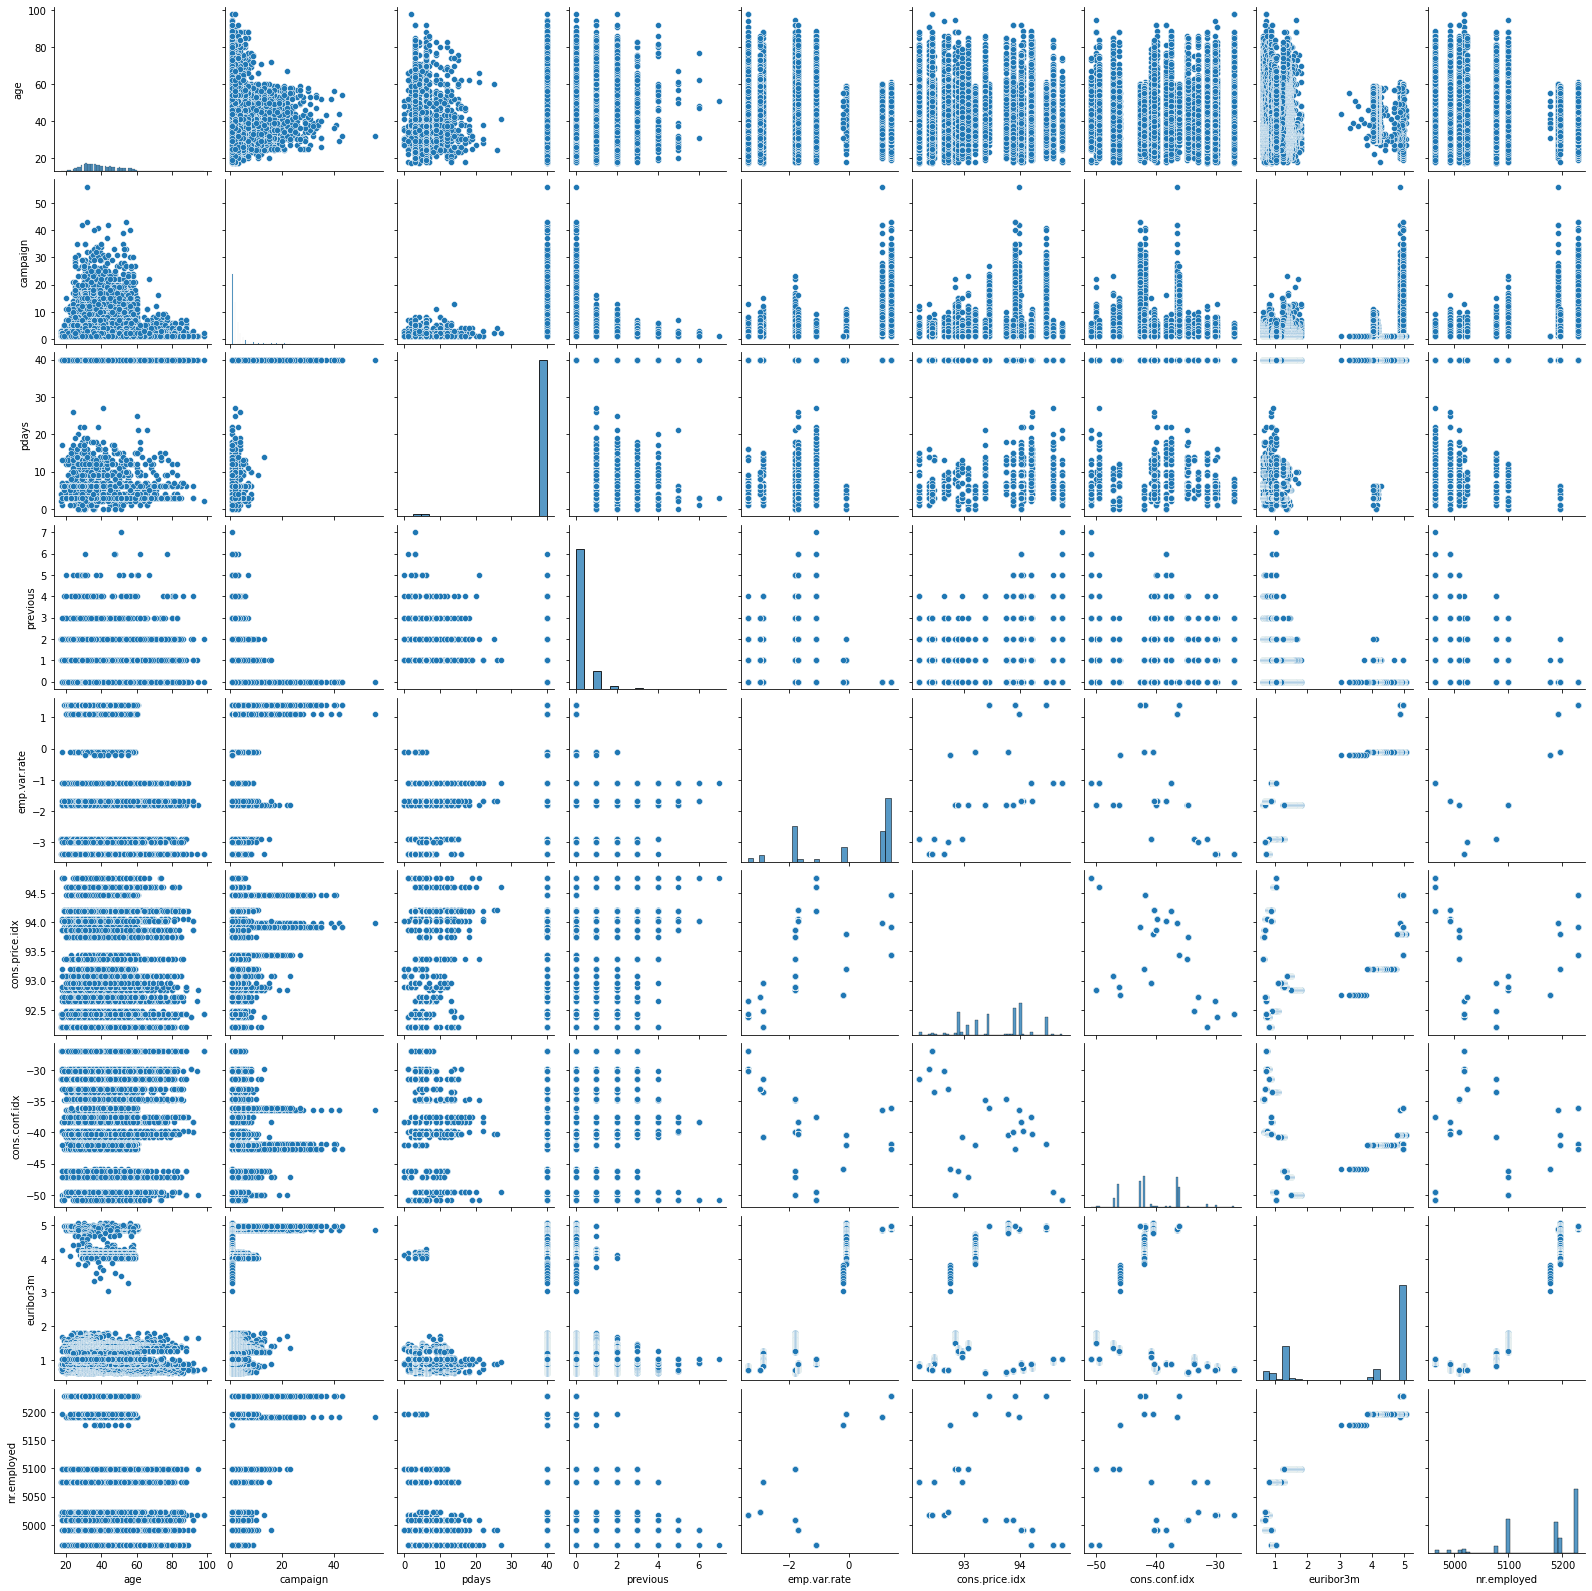

In [17]:
sns.pairplot(data[cont_columns])

### Data Preprocessing for Categorical Variables 

#### Feature Selection using Chi-square test of Significance

* calculate p-value using chisquare test. 
* Using Hypothesis we frame Null hypothesis [ Independent variable] and 
* Alternate Hypothesis [Dependent on target variable]
* Below code conducts chisquare test on categorical variables and finds categorical features depending on target feature

In [19]:
li_significant=[]
def calculate_chisquare_test_statistic(feature ,table):
    # contingency table
#     print(table)
    stat, p, dof, expected = chi2_contingency(table)
#     print('dof=%d' % dof)
#     print(expected)
    # interpret p-value
    alpha = 0.05
    if p <= alpha:
        print('Dependent (reject H0)')
        li_significant.append(feature)
    else:
        print('Independent (fail to reject H0)')
for each_col in categ_columns:
    print(each_col)
    table= pd.crosstab(data[each_col],data['y'])
    calculate_chisquare_test_statistic(each_col, table)

job
Dependent (reject H0)
marital
Dependent (reject H0)
education
Dependent (reject H0)
default
Dependent (reject H0)
housing
Independent (fail to reject H0)
loan
Independent (fail to reject H0)
contact
Dependent (reject H0)
month
Dependent (reject H0)
day_of_week
Dependent (reject H0)
poutcome
Dependent (reject H0)


In [22]:
def transform_categorical_features(feature_1,feature_2):
    df=pd.crosstab(index=data[feature_1],
               columns = data[feature_2])
    print(df.columns)
    df.loc[:,'perc_yes']=df.apply(lambda x: x['yes']/(x['yes']+x['no']),axis=1)
    df.loc[:,'perc_no']=df.apply(lambda x: x['no']/(x['yes']+x['no']),axis=1)
    df.loc[:,'Total_loans_offered']=df.apply(lambda x: (x['yes']+x['no']),axis=1)
    df.sort_values(by='perc_yes')
    return df
transform_categorical_features(feature_1='month',feature_2='y')

Index(['no', 'yes'], dtype='object', name='y')


y,no,yes,perc_yes,perc_no,Total_loans_offered
month,,,,,
apr,2092,539,0.204865,0.795135,2631.0
aug,5521,655,0.106056,0.893944,6176.0
dec,93,89,0.489011,0.510989,182.0
jul,6521,648,0.090389,0.909611,7169.0
jun,4759,559,0.105115,0.894885,5318.0
mar,270,276,0.505495,0.494505,546.0
may,12881,886,0.064357,0.935643,13767.0
nov,3684,416,0.101463,0.898537,4100.0
oct,402,315,0.439331,0.560669,717.0


* For each group we calculate the percentage of positive response 
and bin/group similar categories having same approximately groups range of percentages

In [24]:
job_feature_map_dict= {0.06:['may'],
                      0.10:['jul','nov','jun','aug'],
                      0.2:['apr'],
                      0.44:['oct','sep','mar','dec']}
data['month'].map({e_v:k  for k,v in job_feature_map_dict.items() for e_v in v}).value_counts()

0.10    22763
0.06    13767
0.20     2631
0.44     2015
Name: month, dtype: int64

* We apply similar technique to other categorical features

In [27]:
job_feature_map_dict= {0.0689:['blue-collar','services','entrepreneur'],
                      0.104:['housemaid','self-employed','technician'],
                      0.130:['unknown','management','admin.', 'unemployed'],
                      0.270:['retired','student']}
job_converted= data['job'].map({e_v:k  for k,v in job_feature_map_dict.items() for e_v in v})
edu_feature_map_dict= {0.08:['basic.9y','basic.6y'],
                      0.10:['basic.4y','high.school'],
                      0.135:['professional.course', 'university.degree','unknown'],
                      0.22:['illiterate']}
edu_converted= data['education'].map({e_v:k  for k,v in edu_feature_map_dict.items() for e_v in v})
month_feature_map_dict= {0.06:['may'],
                      0.10:['jul','nov','jun','aug'],
                      0.2:['apr'],
                      0.44:['oct','sep','mar','dec']}
month_converted= data['month'].map({e_v:k  for k,v in month_feature_map_dict.items() for e_v in v})
data_categ= pd.get_dummies(pd.concat([job_converted, edu_converted,month_converted,data['marital'],
          data['default'],data['contact'],
          data['poutcome']],axis=1))
data_model= pd.concat([data_categ, data_cont,data['y'].map({'yes':1,'no':0})],axis=1)
data_model.shape

(41176, 22)

* Correlation with Target Feature

<AxesSubplot:title={'center':'Correlation with Target'}>

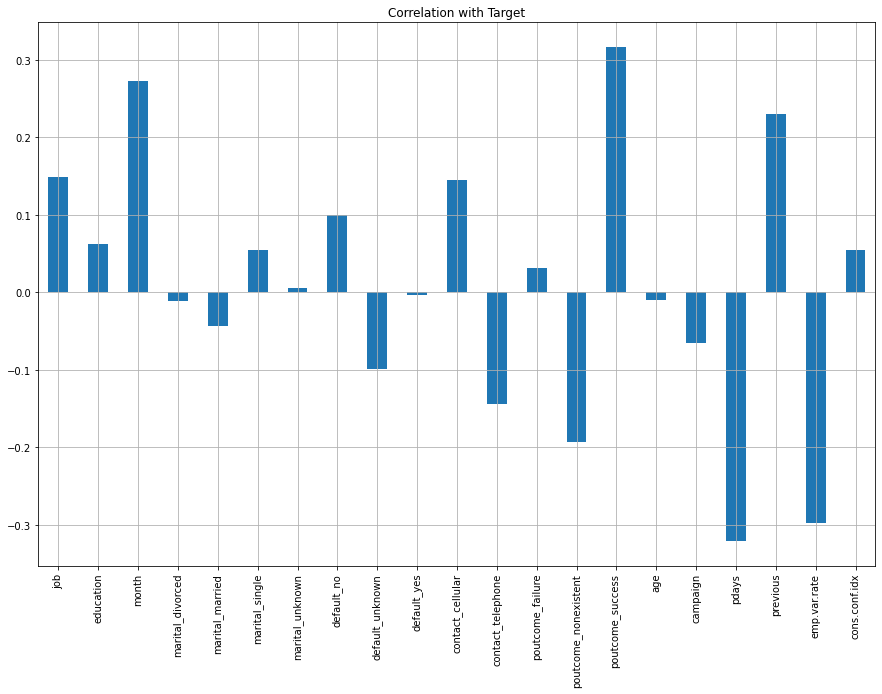

In [26]:
data_model.drop('y',axis=1).corrwith(data_model.y).plot.bar(figsize = (15, 10), title = "Correlation with Target", fontsize = 10,grid = True)

* based on above correlation values we drop non correlating categorical features 

In [28]:
data_model= data_model.drop(['education','marital_divorced','marital_single','marital_unknown'],axis=1)#'age','campaign','cons.conf.idx'

In [29]:
data_model.to_csv('Preprocessed_data.csv',index=False)

In [33]:
data_model.shape

(41176, 18)